In [127]:
import requests
import joblib
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pandas import option_context
from tqdm import tqdm
from statsmodels.stats.inter_rater import aggregate_raters
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mannwhitneyu,shapiro,ttest_ind
from itertools import combinations

import cliffsDelta as cd
import GenerateActivities as gat
import important_features as imf

In [ ]:
QUERY_ROOT = "https://api.github.com"
TOKEN = '' 
HEADERS= {'Authorization':'token '+TOKEN}

## Section 3

### Question 1

#### Write an automated Python script to identify all GitHub bot actors in the list of contributors, by querying the GitHub REST API users endpoint and extracting the required information to make this decision. 

#### More information: You can search for the "type" key in the obtianed JSON result, If it is "Bot", then it is a bot actor, if it is "User", then it is an account.

In [33]:
# 1. Read the given <sample>.csv file into a pandas DataFrame (df).
# 2. Make sure there are 2 columns, one column name is "contributor" that has the name of the contributor, 
#    and another column name is "bothunter_type" that you will use later on in this assignment.
# 3. Display the DataFrame.

df = pd.read_csv("Contributors/sample22.csv")

required_columns = {"contributor", "bothunter_type"}

if not required_columns.issubset(df.columns):
    raise ValueError(f"The CSV file must contain the columns: {required_columns}")

df

,contributor,bothunter_type
0,ChrisRackauckas,Human
1,InessaPawson,Human
2,OriolAbril,Human
3,Stat-Cook,Human
4,adamhsparks,Human
5,allcontributors[bot],Bot
6,anuprulez,Human
7,benjamindonnachie,Human
8,carstenbauer,Human
9,codecov-commenter,Bot


In [34]:
# 1. Store the names of the contributors in a list
# 2. print the list

contributors = df["contributor"].to_list()

In [35]:
# 1. Using a for loop, iterate over each contributor in the list and query the GitHub Users API.
#    You can use "query = f'{QUERY_ROOT}/users/{contributor}'", where QUERY_ROOT is defined at the beginning of this notebook 
#    and 'contributor' is each individual contributor from the list
# 2. Get the response using 'response = requests.get(query, headers=HEADERS)'.
# 3. convert the response to JSON using 'json_response = response.json()'.
# 4. Iterate over each JSON response and get the value of the 'type' key. If it is "Bot" then the contributor is a bot actor, 
#    if "User" then the contributor is an account. You should boolean values to indicate if the contributor is a bot actor (True) or User/Organisation (False)
# 5. Save these results in list of dictionary of the form [{'contributor': <contributor name>, 'app': <boolean value>}, {...}, {...}, {...}].
#    Lets call this list as "app_dict"
# 6. Finally convert this list of dictionary to DataFrame by writing 'pd.DataFrame.from_dict(app_dict)'
# 7. Display the DataFrame. This should have two columns - contributor and app

# Initialize list to store results
app_dict = []

for contributor in contributors:
    query = f"{QUERY_ROOT}/users/{contributor}"
    response = requests.get(query, headers=HEADERS)

    json_response = response.json()
    
    is_bot = json_response.get("type") == "Bot"
    app_dict.append({"contributor": contributor, "app": is_bot})

app_df = pd.DataFrame.from_dict(app_dict)

app_df

,contributor,app
0,ChrisRackauckas,False
1,InessaPawson,False
2,OriolAbril,False
3,Stat-Cook,False
4,adamhsparks,False
5,allcontributors[bot],True
6,anuprulez,False
7,benjamindonnachie,False
8,carstenbauer,False
9,codecov-commenter,False


### Question 2

#### Add a new 'actor' column in the CSV file to store this information. You can write True if it is a bot actor and False if it is not.

#### Report on the total number of GitHub bot actors, and User accounts present in the list of accounts of your dataset.

In [36]:
# Merge the app DataFrame to df by writing 'pd.merge(df, <app df>, on='contributor'). This is similar to SQL join on primary key 'contributor'.
# The resultant df should have 3 columns - contributor, bothunter_type and actor.

merge_df = pd.merge(df, app_df, on="contributor")
merge_df = merge_df.rename(columns={"app":"actor"})

print(merge_df.columns)

print(f"Number of Bot: {len(merge_df[merge_df['actor'] == True])}\nNumber of User: {len(merge_df[merge_df['actor'] == False])}")

merge_df

Index(['contributor', 'bothunter_type', 'actor'], dtype='object')
Number of Bot: 7
Number of User: 33


,contributor,bothunter_type,actor
0,ChrisRackauckas,Human,False
1,InessaPawson,Human,False
2,OriolAbril,Human,False
3,Stat-Cook,Human,False
4,adamhsparks,Human,False
5,allcontributors[bot],Bot,True
6,anuprulez,Human,False
7,benjamindonnachie,Human,False
8,carstenbauer,Human,False
9,codecov-commenter,Bot,False


### Question 3

#### For each bot actor, write their purpose, the task that they automate by looking at their GitHub profile, homepage, information on the GitHub Marketplace, or other documentation that you can find online.


In [37]:
print(merge_df[merge_df["actor"] == True])

bots = {
    "allcontributors": {
        "purpose": "Automates the process of recognizing project contributors.",
        "task":[
            "Adds contributors to a project's README file",
            "Update the contributors list based on their contributions to the project",
            "Add emoji to the contributors to know what he has done in the project"
        ]
    },
    "codecov": {
        "purpose": "Provides automated test coverage reports for codebases.",
        "task":[
            "Analyzes code coverage results from CI/CD pipelines",
            "Generates reports showing which parts of the code are tested",
            "Posts comments on pull requests with coverage changes"
        ]
    },
    "github-actions": {
        "purpose": "Executes workflows and automates software development tasks.",
        "task":[
            "Runs CI/CD pipelines for building, testing, and deploying code",
            "Automates issue and pull request management",
            "Executes scheduled jobs like security scans, backups, or maintenance tasks"
        ]
    },
    "github-advanced-security": {
        "purpose": "Enhances security for GitHub repositories.",
        "task":[
            "Scans repositories for security vulnerabilities and secrets",
            "Provides alerts for potential security risks",
            "Helps enforce security policies like dependency scanning and secret detection"
        ]
    },
    "mergify": {
        "purpose": "Automates pull request merging based on customizable rules.",
        "task": [
            "Merges pull requests when conditions are met"
            "Labels and manages PRs automatically"
            "Helps teams enforce code review workflows efficiently"
        ]
    },
    "netlify": {
        "purpose": "Automates deployment of web applications and static sites.",
        "task":[
            "Deploys sites automatically from GitHub repositories",
            "Provides preview builds for pull requests",
            "Manages DNS, serverless functions, and continuous deployment"
        ]
    },
    "pre-commit-ci": {
        "purpose": "Ensures code quality and formatting by running pre-commit hooks automatically.",
        "task": [
            "Runs configured pre-commit hooks (e.g., formatting, linting, security checks)"
            "Fixes issues automatically and commits changes"
            "Improves code consistency and quality across a project"
        ]
    }
}


                      contributor bothunter_type  actor
5            allcontributors[bot]            Bot   True
10                   codecov[bot]            Bot   True
16            github-actions[bot]            Bot   True
17  github-advanced-security[bot]            Bot   True
26                   mergify[bot]            Bot   True
30                   netlify[bot]            Bot   True
34             pre-commit-ci[bot]            Bot   True


## Section 4

### Question 1

#### Write an automated script to use BIMBAS (Bot Identification Model Based on Activity Sequences) to obtain a prediction of the GitHub contributor type (Bot or Human) for the contributors present in your dataset.

#### Folow the steps given in each cell to use BIMBAS and obtain predictions.

### Read all the events and select the events performed by the contributors present in the given set

In [38]:
# 1. Read the csv file of events (all_events.csv) provided along with this notebook
# 2. Convert created_at column to datetime format 
#    One possible way is to use lambda function: "events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))"
# 3. Get the contributors provided to you in a list or use the contributors list that you created in Section 3 Question 1. 
#    e.g., ['contributor1', 'contributor2', 'contributor3',...]
# 4. Select the events performed by these contributors alone. Do not consider all the events. You should consider only the events
#    performed by the contributors provided to you. Hint: you can use the df.query function
# 5. Display the considered events.


all_events_df = pd.read_csv("all_events.csv")

all_events_df['created_at'] = pd.to_datetime(all_events_df["created_at"], unit='ms')

filtered_contributors_events_df = all_events_df.query("login in @contributors")

filtered_contributors_events_df

,Unnamed: 0,event_id,event_type,login,repository,created_at,action,PR_number,state,PR_node_id,...,comment_node_id,merged,ref,ref_type,issue_number,issue_node_id,issue_closed_at,tag_name,release_node_id,org
3,3,39747379822,IssueCommentEvent,codecov[bot],napari/napari,2024-07-01 00:00:10,created,7043.0,open,PR_kwDOCJ0aI85z_6lX,...,IC_kwDOCJ0aI86DDzXh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari
6,6,39747396929,CommitCommentEvent,github-actions[bot],QuantEcon/lecture-python-intro,2024-07-01 00:01:47,NaN,NaN,NaN,NaN,...,CC_kwDOIy5DFs4IkKwX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QuantEcon
15,15,39747413489,CommitCommentEvent,github-actions[bot],QuantEcon/lecture-python-intro,2024-07-01 00:03:24,NaN,NaN,NaN,NaN,...,CC_kwDOIy5DFs4IkKw0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QuantEcon
16,16,39747416135,PushEvent,github-actions[bot],napari/npe2api,2024-07-01 00:03:40,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari
21,21,39747427332,CreateEvent,github-actions[bot],SciML/PubChem.jl,2024-07-01 00:04:44,NaN,NaN,NaN,NaN,...,NaN,NaN,compathelper/new_version/2024-07-01-00-04-42-9...,branch,NaN,NaN,NaN,NaN,NaN,SciML
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358398,358398,42415372311,IssueCommentEvent,codecov[bot],pybamm-team/PyBaMM,2024-09-30 23:28:49,created,4477.0,closed,PR_kwDOCUVVSc59LeQ9,...,IC_kwDOCUVVSc6OH0Z2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pybamm-team
358401,358401,42415474205,PushEvent,github-actions[bot],Bioconductor/gha-build-jupyter-release-amd64,2024-09-30 23:34:53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bioconductor
358403,358403,42415512378,PushEvent,github-actions[bot],napari/npe2api,2024-09-30 23:37:12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari
358428,358428,42415647911,PushEvent,pre-commit-ci[bot],bokeh/bokeh_sampledata,2024-09-30 23:45:44,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bokeh


### Execute BIMBAS to obtain the predictions

In [39]:
# Do not modify this cell
# Use the following function the code below to obtain your predictions

def execute_bimbas(contributors_list, selected_events):
    '''
    args: contributors_list (list) - list of contributors in the dataset provided to you
          selected_events (DataFrame) - DataFrame of events performed by the considered contributors
    return: bimbas_prediction (DataFrame) - DataFrame of preditions along with the confidence in prediction for each contributor
    '''
    result=pd.DataFrame()
    temp_list = []
    bimbas = joblib.load('bimbas.joblib')
    date_limit = pd.to_datetime(selected_events.created_at.max()) + pd.DateOffset(-90)
    
    for contributor in tqdm(contributors_list):
        # c = contributors[contributor]
        activities = gat.activity_identification(selected_events.query('login==@contributor and created_at>=@date_limit'))
        activity_features = (
                            imf.extract_features(activities)
                            .set_index([[contributor]])
                            )
        # features = pd.concat([features,activity_features])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            probability = bimbas.predict_proba(activity_features)[0][1]
        if(probability <= 0.5):
            contributor_type = 'Human'
        else:
            contributor_type = 'Bot'
        confidence = (abs(probability - 0.5)*2).round(3)
    
        pred = activity_features.set_index([[contributor]]).assign(
            prediction=contributor_type,
            confidence = confidence,
            )
        temp_list.extend([{'contributor':contributor,'bimbas_type':contributor_type,'confidence':confidence}])
    
    bimbas_prediction = pd.DataFrame.from_dict(temp_list)

    return(bimbas_prediction)

In [40]:
# Write your code here to call execute_bimbas function. 
# Pass the contributors list and the filtered events DataFrame as argument to "execute_bimbas" function
# Prediction returned by BIMBAS will have "contributor", "bimbas_type" and "confidence"
# Note: Print the prediction provided by BIMBAS - else this cell will not be graded.


predictions = execute_bimbas(contributors_list=contributors, selected_events=filtered_contributors_events_df)

print(predictions.columns)

print(predictions)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:12<00:00,  3.30it/s]

Index(['contributor', 'bimbas_type', 'confidence'], dtype='object')
                      contributor bimbas_type  confidence
0                 ChrisRackauckas       Human       0.357
1                    InessaPawson       Human       0.943
2                      OriolAbril       Human       0.885
3                       Stat-Cook         Bot       0.801
4                     adamhsparks       Human       0.832
5            allcontributors[bot]         Bot       0.567
6                       anuprulez       Human       0.812
7               benjamindonnachie       Human       0.750
8                    carstenbauer       Human       0.752
9               codecov-commenter         Bot       0.922
10                   codecov[bot]         Bot       0.938
11                      conda-bot         Bot       0.841
12                       dask-bot         Bot       0.265
13               datapumpernickel       Human       0.866
14                         emmaai       Human       0.887
15  

### Create a column in your predictions DataFrame to have predictions provided by BIMBAS. 
### Now your DataFrame should have the following columns - contributor, bothunter_type, app, bimbas_type, confidence 

### Merging bothunter and bimbas predictions

In [41]:
# Merge the predictions provided by BIMBAS to the resultant dataset of Section 3. This final DataFrame should have the following columns - 
# contributor, bothunter_type, actor, bimbas_type, and confidence.

predictions_df = pd.merge(merge_df, predictions, on="contributor")

print(predictions_df.columns)

predictions_df

Index(['contributor', 'bothunter_type', 'actor', 'bimbas_type', 'confidence'], dtype='object')


,contributor,bothunter_type,actor,bimbas_type,confidence
0,ChrisRackauckas,Human,False,Human,0.357
1,InessaPawson,Human,False,Human,0.943
2,OriolAbril,Human,False,Human,0.885
3,Stat-Cook,Human,False,Bot,0.801
4,adamhsparks,Human,False,Human,0.832
5,allcontributors[bot],Bot,True,Bot,0.567
6,anuprulez,Human,False,Human,0.812
7,benjamindonnachie,Human,False,Human,0.750
8,carstenbauer,Human,False,Human,0.752
9,codecov-commenter,Bot,False,Bot,0.922


### Question 2
#### Using Cohen's Kappa compute and report the interrater agreement score between the labels computed by both the bot identification approaches. Mention your interpretation of Cohen's Kappa

In [42]:
# Hint: use the cohen_kappa_score library

# ----------------------------------Compute Cohen’s kappa from SKLEARN--------------------------------------
# This function computes Cohen’s kappa, a score that expresses the level of agreement between two annotators 
# on a classification problem.


ck_score = cohen_kappa_score(y1 = predictions_df["bothunter_type"], y2=predictions_df["bimbas_type"])

print(ck_score)


# Thanks to the description on the official page of the function, 
# we can interpret the result of 0.48 as an indication that the two algorithms classifying the type of contributor 
# only agreed 48% of the time

0.48849104859335035


### Question 3
#### Determine the final type of each contributor. Whenever user_type column has the value "User" check if both bimbas_type and bothunter_type give the same prediction, then consider it as your final prediction in "acc_type" column.
#### For the contributors that have different predictions, i.e. bimbas_type is not same as bothunter_type, then make a manual verification and consider that as the type for that contributor. Add an extra column to the DataFrame ﬁle called 'manual' that has the label determined by you. 
#### For manual verification you can make use the GitHub UI and the GitHub API https://api.github.com/users/username

#### Whenever user_type column has the value "Bot", directly write your final acc_type as "Bot Actor"

#### More information:
For each contributor, you can look at their activities in GitHub UI, look at their latest events using GitHub Events API - https://api.github.com/users/<contributor>/events, to make a decision on their type.

In addition, you can also write a very small reason why do you think they are bot or human (e.g., same activity at regular interval so Bot, files committed and code modified looks like Human, comments look like Human, comment look like Bot, test report looks automated so Bot, and so on....). This will be useful to answer your next question.

In [43]:
print(predictions_df[predictions_df["bothunter_type"] != predictions_df["bimbas_type"]])
print(predictions_df[predictions_df["bothunter_type"] != predictions_df["bimbas_type"]]["contributor"].to_list())

# Write the code for your manual decision here
# example : 
# manual_list_dict = [{'contributor': '<contributor name>', 'manual': '<your prediction>'}, {....}, {....}, {....}]
# pd.DataFrame.from_dict(manual_list_dict)

manual_list_dict = [
    {
        'contributor': "Stat-Cook",
        'manual': "Human"
    },
    {
        'contributor': "conda-bot",
        'manual': "Bot"
    },
    {
        'contributor': "gxydevbot",
        'manual': "Bot"
    },
    {
        'contributor': "hugoledoux",
        'manual': "Human"
    },
    {
        'contributor': "jsagerOffis",
        'manual': "Human"
    },
    {
        'contributor': "koide3",
        'manual': "Human"
    },
    {
        'contributor': "kwrobot",
        'manual': "Bot"
    },
    {
        'contributor': "lucydot",
        'manual': "Human"
    },
    {
        'contributor': "mergify[bot]",
        'manual': "Bot"
    },
    {
        'contributor': "mirror-dump",
        'manual': "Bot"
    },
]

manual_contributor_df = pd.DataFrame.from_dict(manual_list_dict)


     contributor bothunter_type  actor bimbas_type  confidence
3      Stat-Cook          Human  False         Bot       0.801
11     conda-bot          Human  False         Bot       0.841
18     gxydevbot          Human  False         Bot       0.793
19    hugoledoux          Human  False         Bot       0.928
21   jsagerOffis          Human  False         Bot       0.886
22        koide3          Human  False         Bot       0.858
23       kwrobot          Human  False         Bot       0.728
24       lucydot          Human  False         Bot       0.912
26  mergify[bot]            Bot   True       Human       0.786
27   mirror-dump          Human  False         Bot       0.786
['Stat-Cook', 'conda-bot', 'gxydevbot', 'hugoledoux', 'jsagerOffis', 'koide3', 'kwrobot', 'lucydot', 'mergify[bot]', 'mirror-dump']


In [19]:
# Write your code below here to determine the final type of contributor.
# add column named 'acc_type' and write your final decision in it. Final decision is majority of three types - bimbas_type, bothunter_type, manual.

def determine_final_type(row):
    if row['actor']:
        return "Bot Actor"
    
    if row['bimbas_type'] == row['bothunter_type']:
        return row['bimbas_type']

    
    return row['manual']

true_contributor_type_df = pd.merge(predictions_df, manual_contributor_df, how='left', on="contributor")

true_contributor_type_df

# Process each contributor

true_contributor_type_df['acc_type'] = true_contributor_type_df.apply(determine_final_type, axis=1, result_type='expand')

true_contributor_type_df

,contributor,bothunter_type,actor,bimbas_type,confidence,manual,acc_type
0,ChrisRackauckas,Human,False,Human,0.357,NaN,Human
1,InessaPawson,Human,False,Human,0.943,NaN,Human
2,OriolAbril,Human,False,Human,0.885,NaN,Human
3,Stat-Cook,Human,False,Bot,0.801,Human,Human
4,adamhsparks,Human,False,Human,0.832,NaN,Human
5,allcontributors[bot],Bot,True,Bot,0.567,NaN,Bot Actor
6,anuprulez,Human,False,Human,0.812,NaN,Human
7,benjamindonnachie,Human,False,Human,0.750,NaN,Human
8,carstenbauer,Human,False,Human,0.752,NaN,Human
9,codecov-commenter,Bot,False,Bot,0.922,NaN,Bot


### Question 4
#### Study and report the purpose of these identified bots and humans in the repository assigned to you.
#### For example, the purpose can be based on but not limited to - 
##### 1) the type of activities that they are performing (releasing a version on every Sunday, updating the documentation), 
##### 2) type of comments they are posting (reviewing code, test summary report), 
##### 3) when are they triggered (when a new PR is created, when someone in the project ask the bot to merge the code) and so on.  
#### Note: 
##### The purpose can be other than what is provided in examples above.

## Section 5

### Question 1
#### Use the filtered events file that has the events performed by the contributors provided to you
#### Group each event into the following four categories

Issues: IssueCommentEvent, IssuesEvent  
Pull Requests: PullRequestEvent, PullRequestReviewCommentEvent  
Commits: CommitCommentEvent, PushEvent  
Repository: CreateEvent, DeleteEvent, ForkEvent, GollumEvent, MemberEvent, PublicEvent, ReleaseEvent, SponsorshipEvent, WatchEvent  

#### Hint:
1. Add a column called event_group that mentions which event group does that event belong to. Each event (row) should correspond to an event group.  
2. Then perform groupby on ['login','event_group'],  
3. use .agg (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) to count the number of events performed by each contributor in each group,  
4. use pivot with the required arguments (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html). An example is given [here](#pivot_example) in question 2(b), and
5. Reset index and rename axis with None
7. Finally merge it with your 'acc_type' field from the DataFrame you created in Section4, drop contributor, and fillna with 0
8. The final DataFrame should have the following columns - login, PR, commit, issue, repo, acc_type

The final DataFrame should be looking like the following  
![](event_group.png)

In [44]:
# In the resultant DataFrame - each row should corespond to a contributor, and the columns should have all the event groups  
# and the type of the contributor (that you decided in the previous DataFrame) and the values should be the number 
# of events of that event event group the contriubutor has performed.

issue_group = ['IssueCommentEvent', 'IssuesEvent']
pr_group = ['PullRequestEvent', 'PullRequestReviewCommentEvent']
commit_group = ['CommitCommentEvent', 'PushEvent']
repo_group = ['CreateEvent', 'DeleteEvent', 'ForkEvent', 'GollumEvent', 'MemberEvent', 'PublicEvent', 'ReleaseEvent', 'SponsorshipEvent', 'WatchEvent']

In [119]:
def determine_event_group(row):
    if row["event_type"] in issue_group:
        return "Isssues"
    
    if row["event_type"] in pr_group:
        return "Pull Requests"
    
    if row["event_type"] in commit_group:
        return "Commits"
    
    if row["event_type"] in repo_group:
        return "Repository"

filtered_contributors_events_df['event_group'] = filtered_contributors_events_df.apply(determine_event_group, axis=1, result_type='expand')

event_group_filtered_before = filtered_contributors_events_df.groupby(["login", "event_group"]).agg(event_count=('event_group', 'count')).reset_index()

event_group_filtered = event_group_filtered_before.pivot(index='login', columns='event_group', values='event_count').reset_index().rename_axis(None,axis=1)

event_group_filtered = event_group_filtered.rename(columns={"login":"contributor"})

event_group_filtered = pd.merge(event_group_filtered, true_contributor_type_df[["contributor", "acc_type"]], on="contributor")

event_group_filtered = event_group_filtered.fillna(value=0)

event_group_filtered


C:\Users\nico6\AppData\Local\Temp\ipykernel_13496\1170733265.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_contributors_events_df['event_group'] = filtered_contributors_events_df.apply(determine_event_group, axis=1, result_type='expand')


,contributor,Commits,Isssues,Pull Requests,Repository,acc_type
0,ChrisRackauckas,2347.0,1312.0,1355.0,683.0,Human
1,InessaPawson,24.0,19.0,21.0,1.0,Human
2,OriolAbril,81.0,122.0,197.0,39.0,Human
3,Stat-Cook,0.0,15.0,0.0,0.0,Human
4,adamhsparks,78.0,80.0,16.0,26.0,Human
5,allcontributors[bot],23.0,10.0,10.0,10.0,Bot Actor
6,anuprulez,3.0,1.0,6.0,3.0,Human
7,benjamindonnachie,0.0,13.0,3.0,1.0,Human
8,carstenbauer,0.0,13.0,0.0,0.0,Human
9,codecov-commenter,0.0,73.0,0.0,0.0,Bot


### Question 2 (a)

#### Compute the median number of events per event group for Bot+Bot actors and Humans and write in DataFrame.

Row should correspond to type (Bot_BotActor and Human), Column should have Event group name and the values should be the median value of Bot_BotActor or Human for that particular event group. An example is given below

In [22]:
# For example:
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot_app'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot_app
1,event_group1,val2,Human
2,event_group2,val3,Bot_app
3,event_group2,val4,Human
4,event_group3,val5,Bot_app
5,event_group3,val6,Human
6,event_group4,val7,Bot_app
7,event_group5,val8,Human


In [ ]:
df_medians_event = filtered_contributors_events_df.groupby(["login", "event_group"]).agg(event_count=('event_group', 'count')).reset_index()

df_medians_event = df_medians_event.rename(columns={"login":"contributor"})

df_medians_event = pd.merge(df_medians_event, true_contributor_type_df[["contributor", "acc_type"]], on="contributor")

df_medians_event_1 = df_medians_event.replace({"Bot Actor":"Bot_app", "Bot":"Bot_app"})

df_medians_event = df_medians_event_1.groupby(['event_group', 'acc_type'])['event_count'].median().reset_index()

df_medians_event = df_medians_event.rename(columns={'event_count': 'median'})

print(df_medians_event)

     event_group acc_type  median
0        Commits  Bot_app    57.5
1        Commits    Human    20.0
2        Isssues  Bot_app    73.0
3        Isssues    Human    36.0
4  Pull Requests  Bot_app    32.0
5  Pull Requests    Human    27.0
6     Repository  Bot_app    16.0
7     Repository    Human    10.0


### Question 2 (b)

Plot a heatmap of the DataFrame using seaborn - 
1. First convert the dataframe to the required format using pivot, example is given below
2. plot using seaborn - sns.heatmap(df_medians, annot=True, vmin=0, vmax=300, cmap="crest"). More details: https://seaborn.pydata.org/generated/seaborn.heatmap.html)

#### pd.pivot example:
<a id='pivot_example'></a>

In [82]:
# Main DataFrame
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot
1,event_group1,val2,Human
2,event_group2,val3,Bot
3,event_group2,val4,Human
4,event_group3,val5,Bot
5,event_group3,val6,Human
6,event_group4,val7,Bot
7,event_group5,val8,Human


In [83]:
# pivot the main DataFrame
df_medians.pivot(index='acc_type', columns='event_group', values='median')#.reset_index().rename_axis(None,axis=1)

event_group,event_group1,event_group2,event_group3,event_group4,event_group5
acc_type,,,,,
Bot,val1,val3,val5,val7,NaN
Human,val2,val4,val6,NaN,val8


In [84]:
df_medians_event_pivot = df_medians_event.pivot(index='acc_type', columns='event_group', values='median')

df_medians_event_pivot

event_group,Commits,Isssues,Pull Requests,Repository
acc_type,,,,
Bot_app,57.5,73.0,32.0,16.0
Human,20.0,36.0,27.0,10.0


<Axes: xlabel='event_group', ylabel='acc_type'>

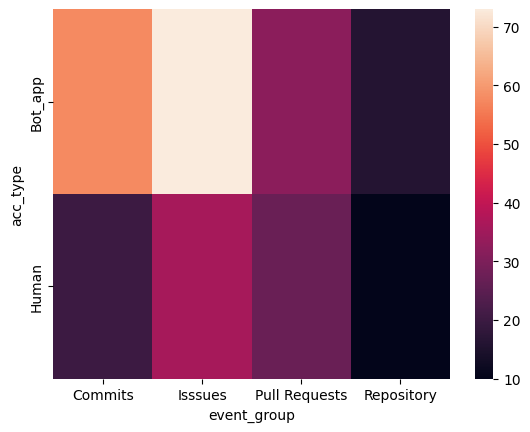

In [85]:
sns.heatmap(df_medians_event_pivot)

#### What is the difference that you observe between Bots+Bot actors and Humans?

The main difference i observe when i compare the Bots+Bot actors and Humans is that Human are much more uniform in term of Commits, Issues, Pull Requests and Repository create. When we look at the bots, we see there is a big chunk of the bot event that is only for Commits and Issues and lot less for the Pull Reuqest and Repository Creation

In [ ]:
# The main difference i observe when i compare the Bots+Bot actors and Humans is that Human are much more uniform in term of Commits, Issues, Pull Requests and Repository create. When we look at the bots, we see there is a big chunk of the bot event that is only for Commits and Issues and lot less for the Pull Reuqest and Repository Creation

#### What is the differnce that you observe between Event groups?

For the humans, it's much more uniform we can have more or less the same number of all the event group
For the bots, it's much more centered on the Commits and the issues (two times more) then on the Pull reuqests and Respository

In [ ]:
# For the humans, it's much more uniform we can have more or less the same number of all the event group
# For the bots, it's much more centered on the Commits and the issues (two times more) then on the Pull reuqests and Respository

#### What is the difference that you observe between Bots+Bot actors and Humans and Event groups all considering at the same time?

As i said already twice, the bot have lot of commits and issues compare to the humans

In [ ]:
# As i said already twice, the bot have lot of commits and issues compare to the humans

### Question 3

#### Create boxen plots to visualise the distribution of number of events in each event group. 
#### For more information you can visit - https://seaborn.pydata.org/generated/seaborn.boxenplot.html#seaborn.boxenplot 
#### You should highlight the data points that correspond to bots using a stripplot in seaborn. https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial  
#### Interpret the results of the visualisation.

C:\Users\nico6\AppData\Local\Temp\ipykernel_13496\2283561769.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Pull Requests', data=event_group_filtered, palette="Set2")


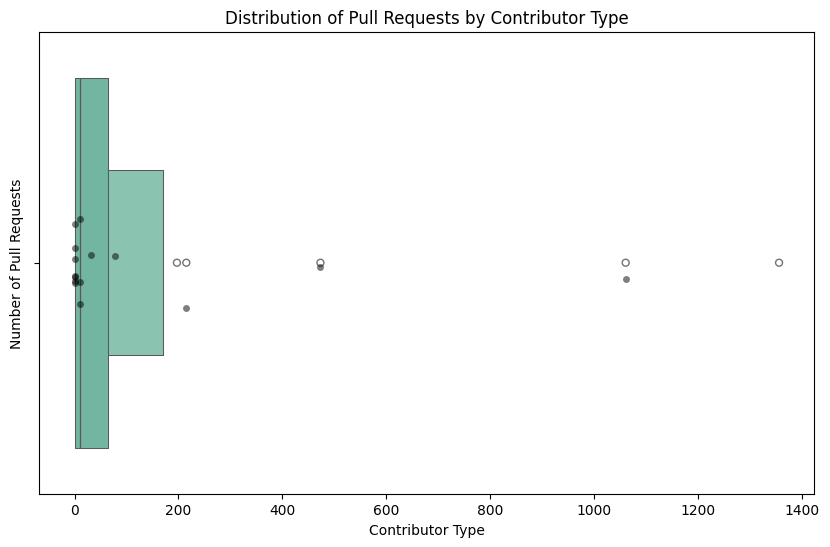

In [106]:
# YOUR CODE BELOW - Visualize number of events from pull request event group

plt.figure(figsize=(10, 6))

sns.boxenplot(x='Pull Requests', data=event_group_filtered, palette="Set2")

sns.stripplot(x='Pull Requests', data=event_group_filtered[event_group_filtered["acc_type"].isin(["Bot", "Bot Actor"])], jitter=True, color='black', alpha=0.5)

plt.title('Distribution of Pull Requests by Contributor Type')
plt.xlabel('Contributor Type')
plt.ylabel('Number of Pull Requests')

plt.show()


C:\Users\nico6\AppData\Local\Temp\ipykernel_13496\2790565925.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Isssues', data=event_group_filtered, palette="Set2")


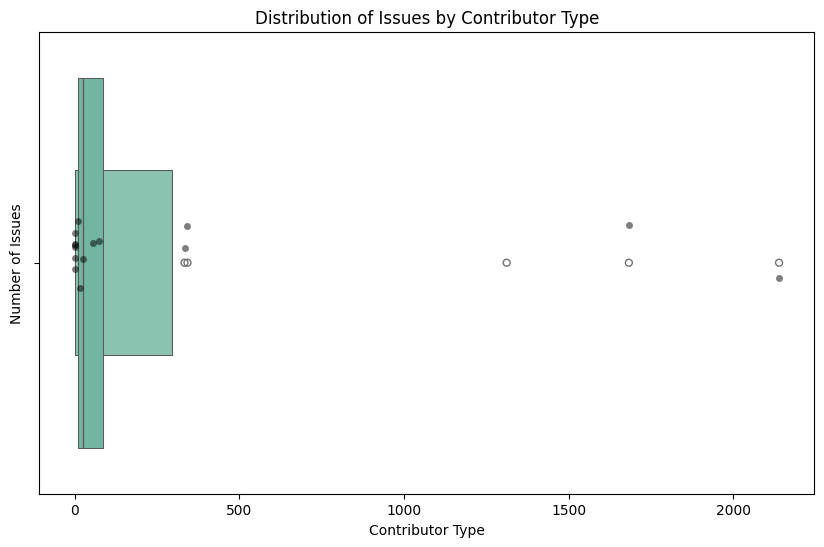

In [113]:
# YOUR CODE BELOW - Visualise number of events from issue event group

plt.figure(figsize=(10, 6))

sns.boxenplot(x='Isssues', data=event_group_filtered, palette="Set2")

sns.stripplot(x='Isssues', data=event_group_filtered[event_group_filtered["acc_type"].isin(["Bot", "Bot Actor"])], jitter=True, color='black', alpha=0.5)

plt.title('Distribution of Issues by Contributor Type')
plt.xlabel('Contributor Type')
plt.ylabel('Number of Issues')

plt.show()


C:\Users\nico6\AppData\Local\Temp\ipykernel_13496\454913188.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Commits', data=event_group_filtered, palette="Set2")


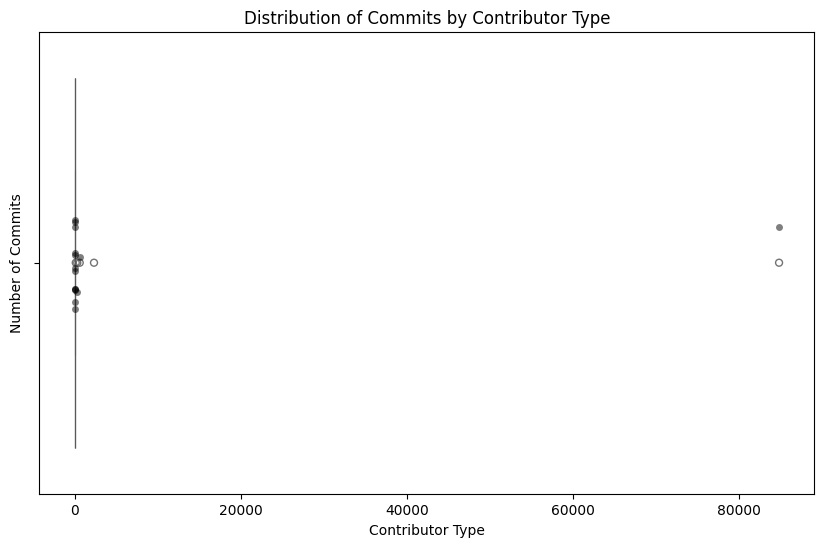

In [114]:
# YOUR CODE BELOW - Visualise number of events from commit event group

plt.figure(figsize=(10, 6))

sns.boxenplot(x='Commits', data=event_group_filtered, palette="Set2")

sns.stripplot(x='Commits', data=event_group_filtered[event_group_filtered["acc_type"].isin(["Bot", "Bot Actor"])], jitter=True, color='black', alpha=0.5)

plt.title('Distribution of Commits by Contributor Type')
plt.xlabel('Contributor Type')
plt.ylabel('Number of Commits')

plt.show()


C:\Users\nico6\AppData\Local\Temp\ipykernel_13496\4187662888.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Repository', data=event_group_filtered, palette="Set2")


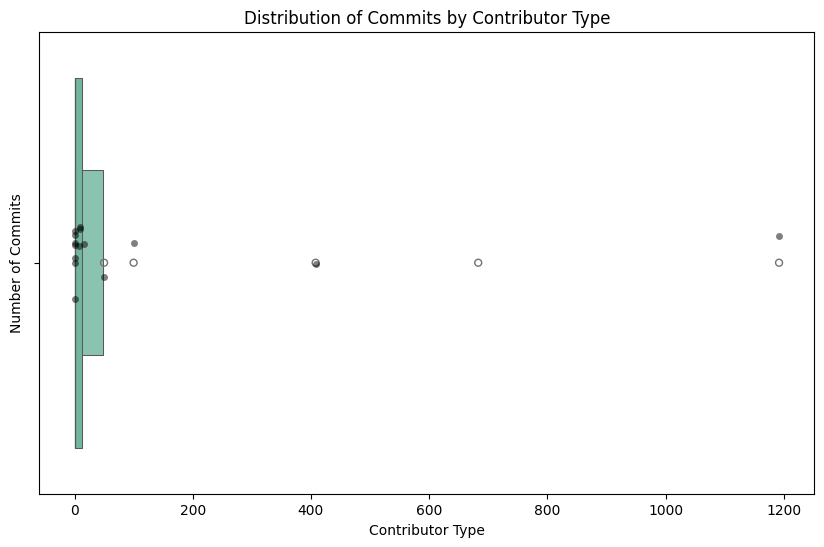

In [115]:
# YOUR CODE BELOW - Visualise number of events from repo event group

plt.figure(figsize=(10, 6))

sns.boxenplot(x='Repository', data=event_group_filtered, palette="Set2")

sns.stripplot(x='Repository', data=event_group_filtered[event_group_filtered["acc_type"].isin(["Bot", "Bot Actor"])], jitter=True, color='black', alpha=0.5)

plt.title('Distribution of Commits by Contributor Type')
plt.xlabel('Contributor Type')
plt.ylabel('Number of Commits')

plt.show()



### Question 4.1

#### Statistical identify whether number of events in each event group is normally distributed or not.
#### Null hypothesis - $H_0$: Sample comes from the data that has normal distribution.
#### Use Shapiro-Wilk test for this purpose. Use the p-value with a threshold of 0.05 to determine whether $H_0$ can be rejected with statistical significance or not. 

#### Use shapiro from scipy.stats to perform this test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

In [128]:
uniform_df = event_group_filtered_before[["event_group", "event_count"]]

event_groups = uniform_df.groupby('event_group')['event_count'].apply(list)

shapiro_results = {}
for group, events in event_groups.items():
    stat, p_value = shapiro(events)
    shapiro_results[group] = {
        'statistic': stat,
        'p_value': p_value,
        'normal_distribution': p_value > 0.05  # True if p-value > 0.05
    }

for group, result in shapiro_results.items():
    print(f"Event Group: {group}")
    print(f"  Statistic: {result['statistic']}")
    print(f"  P-value: {result['p_value']}")
    print(f"  Normally Distributed: {result['normal_distribution']}")
    print()

Event Group: Commits
  Statistic: 0.23412433258284437
  P-value: 9.109629712999211e-10
  Normally Distributed: False

Event Group: Isssues
  Statistic: 0.4731024582754445
  P-value: 6.462410799896444e-10
  Normally Distributed: False

Event Group: Pull Requests
  Statistic: 0.5025934557226175
  P-value: 1.2144682658240346e-08
  Normally Distributed: False

Event Group: Repository
  Statistic: 0.4542643521010382
  P-value: 2.087189721989225e-08
  Normally Distributed: False



### Question 4.2
#### Determine if there is any statistical diﬀerence in number of events between the identified event groups. Perform this test on all pairs of event groups. 
#### Null hypothesis - $H_0$: Any two event group come from the same population.
#### If $H_0$ is rejected in Shapiro-Wilk test (at least for one of the two event groups considered for test), use the Mann-Whitney U statistical test for this purpose. If $H_0$ is not rejected in Shapiro-Wilk test, use the independent t-test for this purpose.  
#### In any case, use the p-value with a threshold of 0.01 to determine whether $H_0$ can be rejected with statistical significance. 

#### Use mannwhitneyu from scipy.stats to perform Mann-Whitney U test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) 
#### or 
#### ttest_ind from scipy.stats to perform independent t-test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html.

#### More information:

You can pass the following arguments to mannwhitneyu from scipy.stats - (method='exact', nan_policy='omit'). For ttest_ind you can use - (nan_policy='omit')

In [129]:
# Perform pairwise tests
pairwise_results = {}
for (group1, events1), (group2, events2) in combinations(event_groups.items(), 2):
    if not shapiro_results[group1]['normal_distribution'] or not shapiro_results[group2]['normal_distribution']:
        # Use Mann-Whitney U test
        stat, p_value = mannwhitneyu(events1, events2)
        test_used = 'Mann-Whitney U'
    
    pairwise_results[(group1, group2)] = {
        'statistic': stat,
        'p_value': p_value,
        'test_used': test_used,
        'different_distribution': p_value < 0.01  # True if p-value < 0.01
    }

# Display the results
for (group1, group2), result in pairwise_results.items():
    print(f"Event Groups: {group1} vs {group2}")
    print(f"  Test Used: {result['test_used']}")
    print(f"  Statistic: {result['statistic']}")
    print(f"  P-value: {result['p_value']}")
    print(f"  Different Distribution: {result['different_distribution']}")
    print()

Event Groups: Commits vs Isssues
  Test Used: Mann-Whitney U
  Statistic: 354.0
  P-value: 0.7435051044750783
  Different Distribution: False

Event Groups: Commits vs Pull Requests
  Test Used: Mann-Whitney U
  Statistic: 328.0
  P-value: 0.7029589070479759
  Different Distribution: False

Event Groups: Commits vs Repository
  Test Used: Mann-Whitney U
  Statistic: 353.5
  P-value: 0.04993783718903961
  Different Distribution: False

Event Groups: Isssues vs Pull Requests
  Test Used: Mann-Whitney U
  Statistic: 531.0
  P-value: 0.44063923485153955
  Different Distribution: False

Event Groups: Isssues vs Repository
  Test Used: Mann-Whitney U
  Statistic: 566.5
  P-value: 0.012537256579666803
  Different Distribution: False

Event Groups: Pull Requests vs Repository
  Test Used: Mann-Whitney U
  Statistic: 422.0
  P-value: 0.11578947785303569
  Different Distribution: False



### Question 4.3
#### Each time you reject the null hypothesis $H_0$, quantify the effect size of the diﬀerence between the groups using cliﬀ’s delta ($\delta$). 
#### To calculate cliﬀ’s delta, you can pass the list of values to cliﬀ delta.py file given in the repository. E.g., cliffsDelta.cliffsDelta(list of values, list of values). This will return the effect size.
#### Refer to the table given in the TP document and mention your interpretation (negligible, small, medium, large).